### This test file shows the basics of using pull requests from websites to obtain data and using these data for analysis

**Load the necessary libraries**

In [1]:
from IPython.display import HTML
import requests
import json
import pandas as pd
import numpy as np
import datetime

Define our the extractor. Can change the arguments, to make it more flexible. Currently is set to m3 (3 months) and looking at "ibm" -> "id": "ibm%3Aus"

In [3]:
def extract_ticks(interval="m3"):
    url = "https://bloomberg-market-and-financial-news.p.rapidapi.com/market/get-chart"
    querystring = {"interval": interval, "id": "ibm%3Aus"}
    headers = {
        'x-rapidapi-host': "bloomberg-market-and-financial-news.p.rapidapi.com",
        'x-rapidapi-key': "ec7cf83d7amsh28327258127105bp16fa52jsn9cf67d1e4463"
    }
    response = requests.request(
        "GET", url, headers=headers, params=querystring)
    json_d = response.json()
    return json_d

Save the data we got from the GET reqeuest

In [4]:
json_d = extract_ticks()

with open("ibm_ytd.json", "w") as fp:
    json.dump(json_d, fp)

Load the data that we just saved and use pandas to visualize it. Note that there are 65 rows, with indicate the 65 "ticks" we pulled from the request. Each tick represents 1 trading day

In [5]:
with open("ibm_ytd.json","r") as fp:
    json_d = json.load(fp)
    
ticks_d = json_d['result']['ibm:us']['ticks']
df = pd.DataFrame(ticks_d)
df['Close'] = df['close']
df['Date'] = df['time'].apply(lambda x:datetime.datetime.fromtimestamp(x))
df = df.set_index('time')
data = df.sort_index(ascending=True, axis=0)
data

,close,volume,Close,Date
time,,,,
1594126800,117.58,4278307,117.58,2020-07-07 15:00:00
1594213200,117.71,5192806,117.71,2020-07-08 15:00:00
1594299600,115.71,4762991,115.71,2020-07-09 15:00:00
1594386000,118.35,4285705,118.35,2020-07-10 15:00:00
1594645200,119.20,4650651,119.20,2020-07-13 15:00:00
...,...,...,...,...
1601470800,121.67,3261235,121.67,2020-09-30 15:00:00
1601557200,121.09,3211661,121.09,2020-10-01 15:00:00
1601643600,120.57,2925228,120.57,2020-10-02 15:00:00


clean the data

In [6]:
new_data = data[['Date','Close']]
index = range(0,len(new_data))
new_data['index']=index
new_data=new_data.set_index('index')
new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data

,Date,Close
index,,
0,2020-07-07 15:00:00,117.58
1,2020-07-08 15:00:00,117.71
2,2020-07-09 15:00:00,115.71
3,2020-07-10 15:00:00,118.35
4,2020-07-13 15:00:00,119.20
...,...,...
60,2020-09-30 15:00:00,121.67
61,2020-10-01 15:00:00,121.09
62,2020-10-02 15:00:00,120.57


Add additional time information, which could have an effect on the stock price

In [7]:
def adddatepart(data,col):
    data['month'] = data[col].dt.month
    data['day'] = data[col].dt.day
    data['year'] = data[col].dt.year
    data['quarter'] = data[col].dt.quarter
    data['dayofweek'] = data[col].dt.dayofweek
    data['dayofyear'] = data[col].dt.dayofyear
    #data['dayinmonth'] = data[col].dt.daysinmonth
    data['is_month_end'] = data[col].dt.is_month_end.astype(int)
    data['is_month_start'] = data[col].dt.is_month_start.astype(int)
    data['is_quarter_start'] = data[col].dt.is_quarter_start.astype(int)
    data['is_quarter_end'] = data[col].dt.is_quarter_end.astype(int)
    data['is_year_start'] = data[col].dt.is_year_start.astype(int)
    data['is_year_end'] = data[col].dt.is_year_end.astype(int)
    data['mon_fri'] = data['dayofweek'].apply(lambda x: 1 if x==0 or x==4 else 0)
    return data
    
adddatepart(new_data,'Date')
new_data

,Date,Close,month,day,year,quarter,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_start,is_quarter_end,is_year_start,is_year_end,mon_fri
index,,,,,,,,,,,,,,,
0,2020-07-07 15:00:00,117.58,7,7,2020,3,1,189,0,0,0,0,0,0,0
1,2020-07-08 15:00:00,117.71,7,8,2020,3,2,190,0,0,0,0,0,0,0
2,2020-07-09 15:00:00,115.71,7,9,2020,3,3,191,0,0,0,0,0,0,0
3,2020-07-10 15:00:00,118.35,7,10,2020,3,4,192,0,0,0,0,0,0,1
4,2020-07-13 15:00:00,119.20,7,13,2020,3,0,195,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2020-09-30 15:00:00,121.67,9,30,2020,3,2,274,1,0,0,1,0,0,0
61,2020-10-01 15:00:00,121.09,10,1,2020,4,3,275,0,1,1,0,0,0,0
62,2020-10-02 15:00:00,120.57,10,2,2020,4,4,276,0,0,0,0,0,0,1


For further data analysis, we split the data into x (date) and y (closing price)

In [8]:
X = new_data.drop('Date',axis=1)
X.drop('Close',axis=1,inplace=True)
Y = new_data['Close']

## Here we create a simple predictor using linear regression

split the data into training and testing, using a 30:70 split

In [9]:
train_pct_index = int(0.7 * len(X))
x_train, x_validate = X[:train_pct_index], X[train_pct_index:]
y_train, y_validate = Y[:train_pct_index], Y[train_pct_index:]

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR 
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [11]:
#make predictions and find the rmse
preds = model.predict(x_validate)
rms=np.sqrt(np.mean(np.power((np.array(y_validate)-np.array(preds)),2)))
# This gives the accuracy of the model, the lesser the better
print("Rms linear reg",rms)

Rms linear reg 5.8440772832863646


Here we can see how the predictions compare to the actual

In [12]:
import matplotlib.pyplot as plt
viz_data = new_data[['Date','Close']]
viz_data['Predictions'] = 0
for i in range(train_pct_index,len(viz_data)):
    viz_data.loc[i,'Predictions'] = preds[i-train_pct_index]
viz_data

,Date,Close,Predictions
index,,,
0,2020-07-07 15:00:00,117.58,0.000000
1,2020-07-08 15:00:00,117.71,0.000000
2,2020-07-09 15:00:00,115.71,0.000000
3,2020-07-10 15:00:00,118.35,0.000000
4,2020-07-13 15:00:00,119.20,0.000000
...,...,...,...
60,2020-09-30 15:00:00,121.67,125.570116
61,2020-10-01 15:00:00,121.09,124.814614
62,2020-10-02 15:00:00,120.57,126.149782


Plotting it

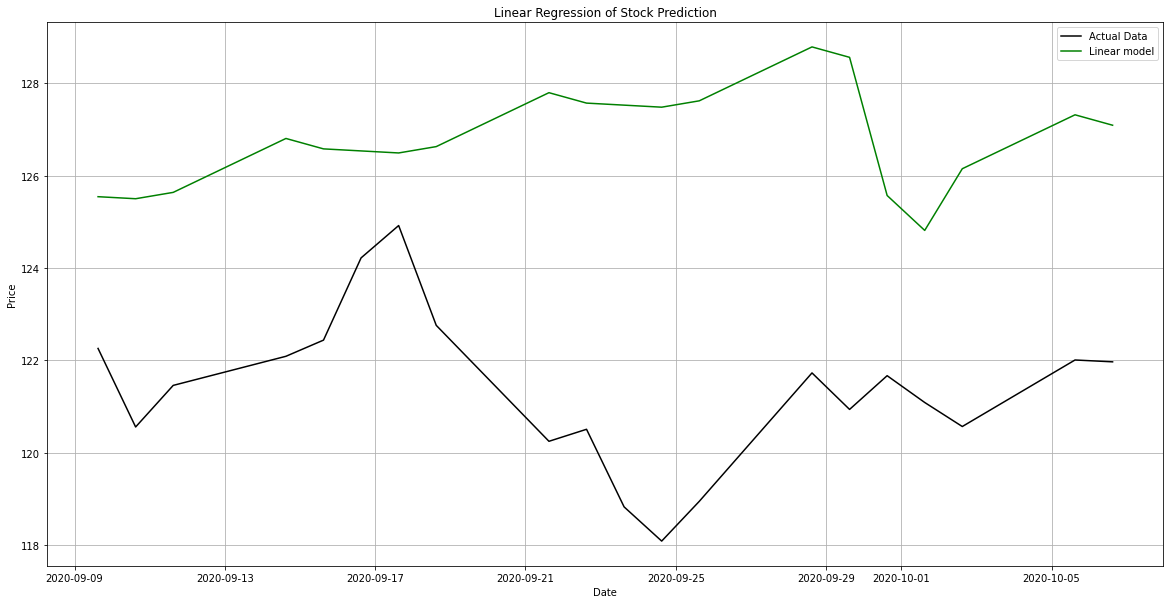

In [13]:
fig= plt.figure(figsize=(20,10))
dates = viz_data['Date'][train_pct_index:]
plt.plot(dates, viz_data['Close'][train_pct_index:], c='k', label='Actual Data')
plt.plot(dates, preds, c='g', label='Linear model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Linear Regression of Stock Prediction')
plt.grid()
plt.legend()
plt.show()

In [11]:
def extract_news2():
    url = "https://google-news.p.rapidapi.com/v1/topic_headlines"
    querystring = {"lang": "en", "topic": "CAAqJAgKIh5DQkFTRUFvS0wyMHZNREkxY25NeWVoSUNaVzRvQUFQAQ"}
    headers = {
        'x-rapidapi-host': "google-news.p.rapidapi.com",
        'x-rapidapi-key': "ec7cf83d7amsh28327258127105bp16fa52jsn9cf67d1e4463"
    }
    response = requests.request(
        "GET", url, headers=headers, params=querystring)
    json_d = response.json()
    return json_d

In [12]:
json_d = extract_news2()

In [13]:
json_d.keys()

dict_keys(['feed', 'articles'])

In [14]:
#feed returns the category and variables of the google search
json_d["feed"]

{'title': 'Gold - Gold - Google News',
 'updated': 'Fri, 09 Oct 2020 12:49:08 GMT',
 'link': 'https://news.google.com/topics/CAAqJAgKIh5DQkFTRUFvS0wyMHZNREkxY25NeWVoSUNaVzRvQUFQAQ?ceid=US:en&hl=en-US&gl=US',
 'language': 'en-US',
 'subtitle': 'Google News',
 'rights': '2020 Google Inc.'}

In [15]:
from newspaper import Article

In [78]:
gold = {"title": [], "link": []}

for i in json_d["articles"]:
    if "gold" or "Gold" in i["title"]:
        gold["title"].append(i["title"])
        gold["link"].append(i["link"])
print(gold["title"])

["Even Europe's gold standard nations are struggling with Covid surges, and it's not winter yet - CNN", 'Gold Standard: What’s gone right, gone wrong, and what should change? - Niners Nation', 'Gold, silver bulls stabilize markets ahead of FOMC minutes - Kitco NEWS', 'Gold Price Forecast - Gold Markets Continue to Try to Fill Gap - FX Empire', 'Gold price holding on to $1900 as U.S. weekly jobless claims rise more than expected - Kitco NEWS', 'Gold Price Futures (GC) Technical Analysis – Trend Changes to Up on Trade Through $1927.00 - FX Empire', 'Why Breast Self-Exams Are No Longer the Gold Standard of Breast Cancer Prevention - Well+Good', 'Some gold with your gas and groceries? Costco enters the gold bullion market - Kitco NEWS', "Gold Market Sells Off Again as Interest Rates Rise Despite ECB 'Smothering' Euro Bond Yields | Gold News - BullionVault", 'Gold Price Forecast - Gold Markets Continue to Grind - FX Empire', 'G999: GSB Gold Standard Banking introduces revolutionary block ch

In [17]:
gold["link"][:5]


['https://news.google.com/__i/rss/rd/articles/CBMiaWh0dHBzOi8vd3d3LmNubi5jb20vMjAyMC8xMC8wNy9ldXJvcGUvZXVyb3Blcy1nb2xkLXN0YW5kYXJkLWNvdW50cmllcy1zdHJ1Z2dsaW5nLWFuYWx5c2lzLWludGwvaW5kZXguaHRtbNIBbWh0dHBzOi8vYW1wLmNubi5jb20vY25uLzIwMjAvMTAvMDcvZXVyb3BlL2V1cm9wZXMtZ29sZC1zdGFuZGFyZC1jb3VudHJpZXMtc3RydWdnbGluZy1hbmFseXNpcy1pbnRsL2luZGV4Lmh0bWw?oc=5',
 'https://news.google.com/__i/rss/rd/articles/CBMicGh0dHBzOi8vd3d3Lm5pbmVyc25hdGlvbi5jb20vMjAyMC8xMC84LzIxNTA4MjEzL2dvbGQtc3RhbmRhcmQtd2hhdHMtZ29uZS1yaWdodC1nb25lLXdyb25nLWFuZC13aGF0LXNob3VsZC1jaGFuZ2XSAX1odHRwczovL3d3dy5uaW5lcnNuYXRpb24uY29tL3BsYXRmb3JtL2FtcC8yMDIwLzEwLzgvMjE1MDgyMTMvZ29sZC1zdGFuZGFyZC13aGF0cy1nb25lLXJpZ2h0LWdvbmUtd3JvbmctYW5kLXdoYXQtc2hvdWxkLWNoYW5nZQ?oc=5',
 'https://news.google.com/__i/rss/rd/articles/CBMiZGh0dHBzOi8vd3d3LmtpdGNvLmNvbS9uZXdzLzIwMjAtMTAtMDcvR29sZC1zaWx2ZXItYnVsbHMtc3RhYmlsaXplLW1hcmtldHMtYWhlYWQtb2YtRk9NQy1taW51dGVzLmh0bWzSAQA?oc=5',
 'https://news.google.com/__i/rss/rd/articles/CBMibmh0dHBzOi8vd3d3LmZ4ZW1w

In [18]:
len(gold["link"])

70

In [19]:
url = gold["link"][1]
article = Article(url)

In [20]:
article.download()
article.html
article.parse()

In [21]:
article.authors

['Rob Guerrera', 'Oct']

In [162]:
article.text

"Editor's Note: With so much market volatility, stay on top of daily news! Get caught up in minutes with our speedy summary of today's must-read news and expert opinions. Sign up here!\n\n(Kitco News) - Gold and silver futures prices are lower in midday U.S. trading Wednesday, but the cash markets show firmer prices. The reason is that the Comex gold and silver futures markets officially closed in early afternoon Tuesday—before the late-afternoon sell offs that were reflected in cash market prices Tuesday afternoon. So futures prices today are reflecting the Tuesday afternoon price pressure. The gold market sold off sharply Tuesday afternoon following President Trump’s tweet calling for an end to U.S. stimulus package discussions in Congress. Lately, the gold market has been acting more like a raw commodity than a safe-haven asset. The yellow metal on many days moves in tandem with the U.S. stock indexes—like Tuesday. December gold futures were last down $19.90 at $1,888.80 and Decembe

In [22]:
article.nlp()

In [23]:
article.keywords

['hit',
 'kinlaw',
 'levin',
 'change',
 'kyle',
 'gone',
 'wrong',
 'whats',
 'shanahan',
 'team',
 'right',
 'week',
 'gold',
 'start',
 'standard']

In [100]:
article.summary

"(Kitco News) - Gold and silver futures prices are lower in midday U.S. trading Wednesday, but the cash markets show firmer prices.\nThe reason is that the Comex gold and silver futures markets officially closed in early afternoon Tuesday—before the late-afternoon sell offs that were reflected in cash market prices Tuesday afternoon.\nBears' next near-term downside price objective is pushing futures prices below solid technical support at the September low of $1,851.00.\nSilver bulls' next upside price objective is closing prices above solid technical resistance at $25.00 an ounce.\nCopper bulls' next upside price objective is pushing and closing prices above solid technical resistance at the September high of 312.10 cents."

In [106]:
type(article.summary)

str

In [105]:
keywords = {}
for i in article.keywords:
    if i in keywords:
        keywords[i] += 1
    else:
        keywords[i] = 1
keywords

{'bulls': 1,
 'cents': 1,
 'minutes': 1,
 'silver': 1,
 'technical': 1,
 'high': 1,
 'support': 1,
 'ahead': 1,
 'gold': 1,
 'price': 1,
 'stabilize': 1,
 'solid': 1,
 'prices': 1,
 'futures': 1,
 'markets': 1,
 'resistance': 1,
 'fomc': 1,
 'market': 1}

In [25]:
import pathlib
import os
import re
pathlib.Path().parent.absolute()

WindowsPath('e:/Study/FastAI/Text Classifier')

In [142]:
re.search(r"([\d]+)",max(os.listdir('to_classify'))).group(0)


'999'

In [145]:
if not os.listdir('to_classify'):
    name = 0
else:
    name = int(re.search(r"([\d]+)",max(os.listdir('to_classify'))).group(0)) + 1
text_file = open(f"to_classify/{name}.txt", "w")
text_file.write(article.summary)
text_file.close()

In [154]:
with open('keywords.txt', 'w') as f:
    print(keywords, file=f)

In [155]:
keywords.close()

In [28]:
import time

In [30]:
keywords = {}
for url in gold["link"]:
    time.sleep(1.0)     #sleep between downloads, otherwise server thinks its an DoS attack due to the many get requests
    article = Article(url)
    try:
        article.download()
    except:
        continue
    article.html
    article.parse()
    article.nlp()
    article.keywords

    if not os.listdir('to_classify'):
        #if folder is empty
        name = 0
    else:
        #for every item in the folder -> extract the digits using re.search -> convert the result to int and append using list comprehension -> find max
        name = max([int(re.search(r"([\d]+)", i).group(0)) for i in os.listdir('to_classify')]) + 1 

    text_file = open(f"to_classify/{name}.txt", "w")
    text_file.write(article.summary)
    text_file.close()
    text_file = open(f"to_classify/full{name}.txt", "w")
    text_file.write(article.text)
    text_file.close()

    for i in article.keywords:
        if i in keywords:
            keywords[i] += 1
        else:
            keywords[i] = 1

ArticleException: Article `download()` failed with ('Connection aborted.', ConnectionResetError(10054, 'Eine vorhandene Verbindung wurde vom Remotehost geschlossen', None, 10054, None)) on URL https://news.google.com/__i/rss/rd/articles/CBMiaWh0dHBzOi8vd3d3LmNubi5jb20vMjAyMC8xMC8wNy9ldXJvcGUvZXVyb3Blcy1nb2xkLXN0YW5kYXJkLWNvdW50cmllcy1zdHJ1Z2dsaW5nLWFuYWx5c2lzLWludGwvaW5kZXguaHRtbNIBbWh0dHBzOi8vYW1wLmNubi5jb20vY25uLzIwMjAvMTAvMDcvZXVyb3BlL2V1cm9wZXMtZ29sZC1zdGFuZGFyZC1jb3VudHJpZXMtc3RydWdnbGluZy1hbmFseXNpcy1pbnRsL2luZGV4Lmh0bWw?oc=5

In [32]:
keywords = {'bulls': 1,
 'cents': 1,
 'minutes': 1,
 'silver': 1,
 'technical': 1,
 'high': 1,
 'support': 1,
 'ahead': 1,
 'gold': 1,
 'price': 1,
 'stabilize': 1,
 'solid': 1,
 'prices': 1,
 'futures': 1,
 'markets': 1,
 'resistance': 1,
 'fomc': 1,
 'market': 1}

In [33]:
keywords

{'bulls': 1,
 'cents': 1,
 'minutes': 1,
 'silver': 1,
 'technical': 1,
 'high': 1,
 'support': 1,
 'ahead': 1,
 'gold': 1,
 'price': 1,
 'stabilize': 1,
 'solid': 1,
 'prices': 1,
 'futures': 1,
 'markets': 1,
 'resistance': 1,
 'fomc': 1,
 'market': 1}

In [2]:
import numpy as np
np.save('keywords.npy', keywords) 

NameError: name 'keywords' is not defined

In [48]:
read_dictionary = np.load('keywords.npy',allow_pickle='TRUE').item()

In [49]:
read_dictionary

{'bulls': 1,
 'cents': 1,
 'minutes': 1,
 'silver': 1,
 'technical': 1,
 'high': 1,
 'support': 1,
 'ahead': 1,
 'gold': 1,
 'price': 1,
 'stabilize': 1,
 'solid': 1,
 'prices': 1,
 'futures': 1,
 'markets': 1,
 'resistance': 1,
 'fomc': 1,
 'market': 1}

In [46]:
#top 5 keywords
sorted(read_dictionary, key=read_dictionary.get, reverse=True)[:5]

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [47]:
sorted(read_dictionary.items(), key=lambda x: x[1], reverse=True)[:5]

[('market', 5), ('futures', 4), ('gold', 3), ('price', 2), ('bulls', 1)]

In [54]:
with open("url_done.txt","w") as f:
    for i in gold["link"]:
        f.write(i + "\n")

In [64]:
with open('url_done.txt') as f:
    url_done = f.read().splitlines()
url_done

['https://news.google.com/__i/rss/rd/articles/CBMiaWh0dHBzOi8vd3d3LmNubi5jb20vMjAyMC8xMC8wNy9ldXJvcGUvZXVyb3Blcy1nb2xkLXN0YW5kYXJkLWNvdW50cmllcy1zdHJ1Z2dsaW5nLWFuYWx5c2lzLWludGwvaW5kZXguaHRtbNIBbWh0dHBzOi8vYW1wLmNubi5jb20vY25uLzIwMjAvMTAvMDcvZXVyb3BlL2V1cm9wZXMtZ29sZC1zdGFuZGFyZC1jb3VudHJpZXMtc3RydWdnbGluZy1hbmFseXNpcy1pbnRsL2luZGV4Lmh0bWw?oc=5',
 'https://news.google.com/__i/rss/rd/articles/CBMicGh0dHBzOi8vd3d3Lm5pbmVyc25hdGlvbi5jb20vMjAyMC8xMC84LzIxNTA4MjEzL2dvbGQtc3RhbmRhcmQtd2hhdHMtZ29uZS1yaWdodC1nb25lLXdyb25nLWFuZC13aGF0LXNob3VsZC1jaGFuZ2XSAX1odHRwczovL3d3dy5uaW5lcnNuYXRpb24uY29tL3BsYXRmb3JtL2FtcC8yMDIwLzEwLzgvMjE1MDgyMTMvZ29sZC1zdGFuZGFyZC13aGF0cy1nb25lLXJpZ2h0LWdvbmUtd3JvbmctYW5kLXdoYXQtc2hvdWxkLWNoYW5nZQ?oc=5',
 'https://news.google.com/__i/rss/rd/articles/CBMiZGh0dHBzOi8vd3d3LmtpdGNvLmNvbS9uZXdzLzIwMjAtMTAtMDcvR29sZC1zaWx2ZXItYnVsbHMtc3RhYmlsaXplLW1hcmtldHMtYWhlYWQtb2YtRk9NQy1taW51dGVzLmh0bWzSAQA?oc=5',
 'https://news.google.com/__i/rss/rd/articles/CBMibmh0dHBzOi8vd3d3LmZ4ZW1w

In [80]:
test = gold["link"]
print(len(test))

70


In [84]:
for idx, val in enumerate(gold["link"]):
    if val in url_done:
        gold["link"].remove(val)
len(gold["link"])

In [85]:
len(gold["link"])

65

In [2]:
import numpy as np
keywords = np.load('keywords.npy', allow_pickle='TRUE').item()
sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:50]

[('gold', 920),
 ('market', 412),
 ('price', 396),
 ('prices', 257),
 ('markets', 168),
 ('support', 143),
 ('vaccine', 137),
 ('stimulus', 134),
 ('silver', 126),
 ('dollar', 124),
 ('week', 116),
 ('investors', 109),
 ('stocks', 99),
 ('analysis', 94),
 ('trading', 94),
 ('ounce', 93),
 ('forecast', 87),
 ('level', 82),
 ('technical', 80),
 ('metals', 78),
 ('futures', 77),
 ('inflation', 72),
 ('continue', 67),
 ('higher', 67),
 ('stock', 67),
 ('report', 64),
 ('think', 64),
 ('global', 64),
 ('high', 63),
 ('rates', 62),
 ('low', 58),
 ('precious', 53),
 ('analysts', 51),
 ('going', 50),
 ('data', 50),
 ('xauusd', 50),
 ('buy', 49),
 ('record', 46),
 ('risk', 46),
 ('2021', 45),
 ('metal', 44),
 ('target', 44),
 ('covid19', 44),
 ('rally', 44),
 ('weeks', 42),
 ('economic', 42),
 ('bitcoin', 40),
 ('likely', 40),
 ('weekly', 39),
 ('biden', 39)]

In [89]:
type(sorted(keywords, key=keywords.get, reverse=True)[:5])

list

In [93]:
a = {'bulls': 1,
 'cents': 1,
 'minutes': 1,
 'technical': 1,
 'high': 1,
 'support': 1,
 'solid': 1,
 'futures': 1,
 'resistance': 1,
 'fomc': 1,}
a.keys()

dict_keys(['bulls', 'cents', 'minutes', 'technical', 'high', 'support', 'solid', 'futures', 'resistance', 'fomc'])

In [94]:
if any(e in sorted(keywords, key=keywords.get, reverse=True)[:5] for e in a.keys()):
    print("true")
else:
    print("false")

false


In [92]:
sorted(keywords, key=keywords.get, reverse=True)[:5]

['gold', 'price', 'standard', 'market', 'prices']

In [62]:
import requests
import json
from newspaper import Article
from newspaper import Config
import pathlib
import os
import re
import time
import numpy as np


# user_agent specification. Dont know if it is necessary. Mixed results
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent

# extract all URLs from Google topics


def extract_news2():
    url = "https://google-news.p.rapidapi.com/v1/topic_headlines"
    querystring = {
        "lang": "en", "topic": "CAAqJAgKIh5DQkFTRUFvS0wyMHZNREkxY25NeWVoSUNaVzRvQUFQAQ"}  # the long topic alphanumerical code stands for "gold"
    headers = {
        'x-rapidapi-host': "google-news.p.rapidapi.com",
        'x-rapidapi-key': "ec7cf83d7amsh28327258127105bp16fa52jsn9cf67d1e4463"
    }
    response = requests.request(
        "GET", url, headers=headers, params=querystring)
    json_d = response.json()
    return json_d


json_d = extract_news2()
print("found articles:", len(json_d["articles"]))

# create a dictionary will all the titles and links. Append all found articles if they have specific words in their title.
gold = {"title": [], "link": []}
for i in json_d["articles"]:
    if "gold" or "Gold" or "GOLD" or "XAU" in i["title"]:
        gold["title"].append(i["title"])
        gold["link"].append(i["link"])

print("articles with gold:", len(gold["link"]))

# load the keywords data into a dictionary. This is done to further reduce articles based on their text content.
keywords = np.load('keywords.npy', allow_pickle='TRUE').item()

# load the url_done.txt and remove any of the links that have been done before
with open('url_done.txt') as f:
    url_done = f.read().splitlines()

for idx, val in enumerate(gold["link"]):
    if val in url_done:
        gold["link"].remove(val)
print("after url_done:", len(gold["link"]))

found articles: 70
articles with gold: 70
after url_done: 51


In [63]:
for idx, val in enumerate(gold["link"]):
    if val in url_done:
        print("dup")
        gold["link"].remove(val)
    else:
        print(val)

https://news.google.com/__i/rss/rd/articles/CBMiZmh0dHBzOi8vd3d3LmZ4ZW1waXJlLmNvbS9mb3JlY2FzdHMvYXJ0aWNsZS9nb2xkLXByaWNlLWZvcmVjYXN0LWdvbGQtbWFya2V0cy1jb250aW51ZS10by1maWdodC0yLTY3ODAwMtIBAA?oc=5
https://news.google.com/__i/rss/rd/articles/CBMiY2h0dHBzOi8vd3d3LmtpdGNvLmNvbS9uZXdzLzIwMjAtMTAtMTQvQXQtMS05MDAtZ29sZC1pcy1zdGlsbC1jaGVhcC1mb3JtZXItQmVhci1TdGVhcm5zLWFuYWx5c3QuaHRtbNIBAA?oc=5
https://news.google.com/__i/rss/rd/articles/CBMiU2h0dHBzOi8vc2Vla2luZ2FscGhhLmNvbS9hcnRpY2xlLzQzNzkxMjMtZ29sZC1tZXRhbHMtYXJlLWZpbmFsbHktcmVhZHktZm9yLXRha2Utb2Zm0gFXaHR0cHM6Ly9zZWVraW5nYWxwaGEuY29tL2FtcC9hcnRpY2xlLzQzNzkxMjMtZ29sZC1tZXRhbHMtYXJlLWZpbmFsbHktcmVhZHktZm9yLXRha2Utb2Zm?oc=5
https://news.google.com/__i/rss/rd/articles/CBMiZmh0dHBzOi8vd3d3LmtpdGNvLmNvbS9uZXdzLzIwMjAtMTAtMTUvVGhlLWdvbGQtcHJpY2UtaXMtc3ViZHVlZC1haGVhZC1vZi10aGUtRXVyb3BlYW4tbWFya2V0LW9wZW4uaHRtbNIBAA?oc=5
https://news.google.com/__i/rss/rd/articles/CBMiPWh0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjAvMTAvMTUvZ29sZC1tYXJrZXRzLWNvcm9uYXZpcnVzLmh0bW

In [65]:
original = 0
actual = 0
for url in gold["link"]:
    article = Article(url)
    original += 1
    try:
        article.download()
        article.parse()
    except:
        print("not downloaded")
        continue
    article.nlp()
    # check if the article has keywords associated with the top 10 keywords related to the subject. Only write if true
    #sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:10]      #will return both the key and value
    if sum([1 for e in article.keywords if e in sorted(keywords, key=keywords.get, reverse=True)[:10]]) >= 2:
        pass
    else:
        continue
    print(article.title)
    actual += 1
print("original: %i, actual: %i" % (original, actual))

Gold Price Forecast – Gold Markets Continue to Fight
At $1,900 gold is still cheap - former Bear Stearns analyst
not downloaded
The gold price is subdued ahead of the European market open
Gold inches down as dollar strengthens on U.S. stimulus delay
G999: Josip Heit and the GSB Gold Standard in the cosmos of the blockchain financial industry
Gold Price Drops with Stocks as Covid Crisis Worsens, Inflation Stalls, Financial Trouble 'Not Even Started'
Gold Bars Back Above $1900 as China Hoards 'Strategic' Resources, Beijing Excludes Mongols from 'Shared Vision for Humanity'
Silver Price Forecast – Silver Markets Continue to Find Interest
Gold prices slip below $1,900 level as coronavirus lockdowns gain steam
US Close- Stocks drop on bank earnings and stimulus stalemate, Oil and Gold rally on softer dollar - MarketPulse
Barrick Gold produced 1.16 million ounces of gold in third quarter
Why African Investors Are Officially Dumping Gold for Bitcoin
GLOBAL MARKETS -World stocks whipsaw on pan

In [61]:
sorted(keywords, key=keywords.get, reverse=True)[:5]

['gold', 'price', 'market', 'standard', 'stimulus']

In [ ]:
# download the article, do NLP, get summary and keywords. write in file.
for url in gold["link"]:
    # sleep between downloads, otherwise server thinks its an DoS attack due to the many get requests
    time.sleep(1.0)
    article = Article(url)
    try:
        article.download()
        article.parse()
    except:
        continue
    article.nlp()
    # check if the article has keywords associated with the top 10 keywords related to the subject. Only write if true
    '''
    #sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:10]      #will return both the key and value
    if any(e in sorted(keywords, key=keywords.get, reverse=True)[:10] for e in a.keys()):
        pass
    else:
        continue
    '''
    # get file name based on the items in the folder
    if not os.listdir('to_classify'):
        # if folder is empty
        name = 0
    else:
        # for every item in the folder -> extract the digits using re.search -> convert the result to int and append using list comprehension -> find max
        name = max([int(re.search(r"([\d]+)", i).group(0))
                    for i in os.listdir('to_classify')]) + 1

    # write the article summary in a text file and save in folder using the naming scheme above. The try and except are used to prevent loop stopping due to weird article summary.
    try:
        text_file = open(f"to_classify/{name}.txt", "w")
        text_file.write(article.summary)
        text_file.close()
        # save the text for cross-validification of the summary
        text_file = open(f"to_classify/full{name}.txt", "w")
        text_file.write(article.text)
        text_file.close()
    except:
        print("could not write", url)
        continue

    # update the keywords with every iteration/article
    for i in article.keywords:
        if i in keywords:
            keywords[i] += 1
        else:
            keywords[i] = 1

# save the updated keywords after all articles have been done
np.save('keywords.npy', keywords)

# update the url_done text by appending all the new urls that have been processed.
with open("url_done.txt", "a") as f:
    for i in gold["link"]:
        f.write(i + "\n")


In [1]:
from newspaper import Article
from newspaper import Config
import datetime

today = datetime.datetime.today()
yesterday = today - datetime.timedelta(days=1)
url="https://www.kitco.com/news/2020-11-29/Gold-is-off-more-than-250-from-August-s-record-highs-but-here-s-why-the-bull-run-is-not-over.html"
url2 = "https://www.fxempire.com/forecasts/article/gold-price-futures-gc-technical-analysis-forecast-weakens-under-1780-50-strengthens-over-1788-10-685697"
article = Article(url)
try:
    article.download()
    article.parse()
except:
    print("could not download or parse", url)
publish_time = article.publish_date
print(publish_time.strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d'), yesterday.strftime('%Y-%m-%d'))

2020-11-29 2020-11-30 2020-11-29


In [92]:
if publish_time != None:
    if publish_time.strftime('%Y-%m-%d') != today.strftime('%Y-%m-%d') and publish_time.strftime('%Y-%m-%d') != yesterday.strftime('%Y-%m-%d'):
        #print("today or yesterday")
        print(publish_time)
    else:
        print("today or yesterday")
        #print(publish_time)
else:
    print("none")

today or yesterday


In [42]:
#yesterday
today = datetime.datetime.today()
yesterday = today - datetime.timedelta(days=1)
yesterday.strftime('%Y-%m-%d')

'2020-11-29'

In [36]:
if not publish_time:
    print("no")
else:
    print(publish_time)

no


In [94]:
article.text

"Editor's Note: Get caught up in minutes with our speedy summary of today's must-read news stories and expert opinions that moved the precious metals and financial markets. Sign up here!\n\n(Kitco News) Why is gold down more than $250 from its summer record highs, and does it have more to lose? This week’s market rundown will look at why analysts say that the bull run is actually not over.\n\nThis week gold dropped below $1,800. There were a few triggers behind that move, including the rally in the stock market, some better-than-expected economic data, and positive vaccine news.\n\nBut the majority of analysts Kitco News spoke to this week said that they see gold stabilizing around the $1,800 level and project higher prices next year.\n\nAustralia and New Zealand Banking Group (ANZ) said that the vaccine news does not actually change the major drivers that took gold higher this year, citing real interest rates, inflation, and a weaker U.S. dollar as the triggers that will take gold to 

In [98]:
text_file = open(f"test.txt", "w")
text_file.write("%s\n %s" % (publish_time, article.text))
text_file.close()